In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Importing prequiste package for case study

In [2]:
# importing required libraries
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
from keras.layers import Input, Embedding, LSTM, Dropout, BatchNormalization, Dense, concatenate, Flatten, Conv1D, MaxPool1D, LeakyReLU, ELU, SpatialDropout1D, MaxPooling1D, GlobalAveragePooling1D, GlobalMaxPooling1D
from keras.preprocessing.text import Tokenizer, one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model, load_model
from keras import regularizers
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard, ReduceLROnPlateau
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import roc_auc_score
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
import re
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import pickle

Using TensorFlow backend.


### Pre-processing steps

In [0]:
# We clean the essay text data
# For this task, we have defined some helper functions
# The same function and code snippet will be used to clean project title
# https://stackoverflow.com/a/47091490/4084039

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

# https://gist.github.com/sebleier/554280

stopwords= ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"]

In [0]:
# Cleaning Text feature
preprocessed_text = []
# tqdm is for printing the status bar
for sentance in tqdm(project_data['text'].values):
    sent = decontracted(sentance)
    sent = sent.replace('\\r', ' ')
    sent = sent.replace('\\"', ' ')
    sent = sent.replace('\\n', ' ')
    sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
    # https://gist.github.com/sebleier/554280
    sent = ' '.join(e for e in sent.split() if e not in stopwords)
    preprocessed_text.append(sent.lower().strip())

100%|██████████| 109248/109248 [01:00<00:00, 1818.57it/s]


In [0]:
project_data["clean_text"] = preprocessed_text

In [0]:
project_data = project_data.drop(['Unnamed: 0', 'id', 'teacher_id',
                                  'project_submitted_datetime','text'],axis=1)

In [0]:
# we have categorical features also, will do cleaning one by one

# https://stackoverflow.com/questions/36383821/pandas-dataframe-apply-function-to-column-strings-based-on-other-column-value
project_data['project_grade_category'] = project_data['project_grade_category'].str.replace(' ','_')
project_data['project_grade_category'] = project_data['project_grade_category'].str.replace('-','_')
project_data['project_grade_category'] = project_data['project_grade_category'].str.lower()


project_data['project_subject_categories'] = project_data['project_subject_categories'].str.replace(' The ','')
project_data['project_subject_categories'] = project_data['project_subject_categories'].str.replace(' ','')
project_data['project_subject_categories'] = project_data['project_subject_categories'].str.replace('&','_')
project_data['project_subject_categories'] = project_data['project_subject_categories'].str.replace(',','_')
project_data['project_subject_categories'] = project_data['project_subject_categories'].str.lower()


project_data['teacher_prefix']=project_data['teacher_prefix'].fillna('Mrs.')
project_data['teacher_prefix'] = project_data['teacher_prefix'].str.replace('.','')
project_data['teacher_prefix'] = project_data['teacher_prefix'].str.lower()


project_data['project_subject_subcategories'] = project_data['project_subject_subcategories'].str.replace(' The ','')
project_data['project_subject_subcategories'] = project_data['project_subject_subcategories'].str.replace(' ','')
project_data['project_subject_subcategories'] = project_data['project_subject_subcategories'].str.replace('&','_')
project_data['project_subject_subcategories'] = project_data['project_subject_subcategories'].str.replace(',','_')
project_data['project_subject_subcategories'] = project_data['project_subject_subcategories'].str.lower()

project_data['school_state'] = project_data['school_state'].str.lower()

In [0]:
# we will extract numerical digits from the project resource summary

project_summary_numerical = []
for sentance in tqdm(project_data['project_resource_summary']):
    sent1 = decontracted(sentance)
    sent1 = ' '.join(e for e in sent1.split() if e.isdigit())
    k=len(sent1)
    project_summary_numerical.append(k)

project_data["project_summary_numerical"] = project_summary_numerical

100%|██████████| 109248/109248 [00:01<00:00, 71911.93it/s]


### Loading data and topic modeling feature files

In [0]:
project_data = pd.read_csv('/content/drive/My Drive/project_data2.csv')

In [4]:
project_data.head(2)

,teacher_prefix,school_state,project_submitted_datetime,project_grade_category,project_title,project_essay_1,project_essay_2,project_essay_3,project_essay_4,project_resource_summary,teacher_number_of_previously_posted_projects,project_is_approved,clean_categories,clean_subcategories,price,quantity,digit_in_summary,clean_text,month,weekday,hour,month_Day,project_summary_numerical
0,mrs,in,2016-12-05 13:43:57,grades_prek_2,Educational Support for English Learners at Home,My students are English learners that are work...,"\""The limits of your language are the limits o...",NaN,NaN,My students need opportunities to practice beg...,0,0,literacy_language,eslliteracy,154.6,23,0,my students english learners working english s...,12,0,13,5,0
1,mr,fl,2016-10-25 09:22:10,grades_6_8,Wanted: Projector for Hungry Learners,Our students arrive to our school eager to lea...,The projector we need for our school is very c...,NaN,NaN,My students need a projector to help with view...,7,1,history_civicshealth_sports,civics_governmentteamsports,299.0,1,0,our students arrive school eager learn they po...,10,1,9,25,0


In [0]:
target = project_data["project_is_approved"]
features = project_data.drop(["project_resource_summary","project_is_approved"],axis=1)

### Splitting data into train and test

In [0]:
# We split our dataset into train,cross-validation and test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(features, target, stratify=target,test_size=0.20,random_state=123)

#### Vectorizing our text feature

In [0]:
# Filtering Text Data based on idf values

tfidf = TfidfVectorizer()
combine_tfidf = tfidf.fit_transform(X_train["clean_text"])

# converting to dictionary
combine_dict = dict(zip(tfidf.get_feature_names(),list(tfidf.idf_)))

In [0]:
tfidf_df = pd.DataFrame(list(combine_dict.items()), columns=['Words', 'IDF Values'])

In [0]:
tfidf_df = tfidf_df.sort_values(by ='IDF Values' )

In [0]:
corpus = tfidf_df["Words"].tolist()

In [0]:
# convert the sentences (strings) into integers
tokenizer = Tokenizer()
tokenizer.fit_on_texts(corpus)
sequences_train = tokenizer.texts_to_sequences(X_train["clean_text"])
sequences_test = tokenizer.texts_to_sequences(X_test["clean_text"])

In [12]:
# get word -> integer mapping
word2idx = tokenizer.word_index
print('Found %s unique tokens.' % len(word2idx))

Found 51720 unique tokens.


In [13]:
encoded_train = pad_sequences(sequences_train,maxlen=300,padding='post', truncating='post')
print('Shape of data tensor:', encoded_train.shape)

Shape of data tensor: (87398, 300)


In [14]:
encoded_test = pad_sequences(sequences_test, maxlen=300,padding='post', truncating='post')
print('Shape of data tensor:', encoded_test.shape)

Shape of data tensor: (21850, 300)


In [0]:
# Loading Embedding File

pickle_in = open("drive/My Drive/Lstm_donor_choose/glove_vectors","rb")
glove_words = pickle.load(pickle_in)

#### Embedding matrix

In [0]:
num_words = len(word2idx) + 1
embedding_matrix = np.zeros((num_words, 300))
for word, i in word2idx.items():
  if i < 13271:
    embedding_vector = glove_words.get(word)
    if embedding_vector is not None:
      # words not found in embedding index will be all zeros.
      embedding_matrix[i] = embedding_vector

In [17]:
# load pre-trained word embeddings into an Embedding layer which already trained on text data
embedding_layer = Embedding(
  num_words,
  300,
  weights=[embedding_matrix],
  input_length=300,
  trainable=False
)
input_essay_text = Input(shape=(300,),name="input_text")
x = embedding_layer(input_essay_text)
x = LSTM(100,recurrent_dropout=0.5,kernel_regularizer=regularizers.l2(0.001),return_sequences=True)(x)
flatten_essay_layer = Flatten()(x)

W0905 08:04:48.295456 140092391679872 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:66: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0905 08:04:48.316234 140092391679872 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:541: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0905 08:04:48.319796 140092391679872 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4432: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0905 08:04:48.331636 140092391679872 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:190: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0905 08:04:48.332684 1400923916

## Here we will be using Countvectorizer for remaining features

#### Teacher Prefix feature

In [0]:
prefix_vectorizer = CountVectorizer(binary=True)

encoder_prefix_train = prefix_vectorizer.fit_transform(X_train["teacher_prefix"])
encoder_prefix_test = prefix_vectorizer.transform(X_test["teacher_prefix"])

### School state feature

In [0]:
school_state_vectorizer = CountVectorizer(binary=True)

encoder_state_train = school_state_vectorizer.fit_transform(X_train["school_state"])
encoder_state_test = school_state_vectorizer.transform(X_test["school_state"])

### Project Grade category

In [0]:
project_grade_vectorizer = CountVectorizer(binary=True)

encoder_grade_train = project_grade_vectorizer.fit_transform(X_train["project_grade_category"])
encoder_grade_test = project_grade_vectorizer.transform(X_test["project_grade_category"])

### Clean category

In [0]:
project_category_vectorizer = CountVectorizer(binary=True)

encoder_cat_train = project_category_vectorizer.fit_transform(X_train["clean_categories"])
encoder_cat_test = project_category_vectorizer.transform(X_test["clean_categories"])

### Clean sub category

In [0]:
project_subcategory_vectorizer = CountVectorizer(binary=True)

encoder_subcat_train = project_subcategory_vectorizer.fit_transform(X_train["clean_subcategories"])
encoder_subcat_test = project_subcategory_vectorizer.transform(X_test["clean_subcategories"])

### Numerical feature

**Tried with extra time based feature result was approx same so neglected time based feature**

In [0]:
num_train_1=X_train['project_summary_numerical'].values.reshape(-1, 1)
num_train_2=X_train['price'].values.reshape(-1, 1)
num_train_3=X_train['quantity'].values.reshape(-1, 1)
num_train_4=X_train['teacher_number_of_previously_posted_projects'].values.reshape(-1, 1)
# num_train_5=X_train['month'].values.reshape(-1,1) 
# num_train_6=X_train['month_Day'].values.reshape(-1,1)
# num_train_7=X_train['weekday'].values.reshape(-1,1)
# num_train_8=X_train['hour'].values.reshape(-1,1) 


num_test_1=X_test['project_summary_numerical'].values.reshape(-1, 1)
num_test_2=X_test['price'].values.reshape(-1, 1)
num_test_3=X_test['quantity'].values.reshape(-1, 1)
num_test_4=X_test['teacher_number_of_previously_posted_projects'].values.reshape(-1, 1)
# num_test_5=X_test['month'].values.reshape(-1,1) 
# num_test_6=X_test['month_Day'].values.reshape(-1,1)
# num_test_7=X_test['weekday'].values.reshape(-1,1)
# num_test_8=X_test['hour'].values.reshape(-1,1)

num_train=np.concatenate((num_train_1,num_train_2,num_train_3,num_train_4),axis=1)

num_test=np.concatenate((num_test_1,num_test_2,num_test_3,num_test_4),axis=1)


**Standarize our numerical data**

In [0]:
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
numerical_train=scaler.fit_transform(num_train)
numerical_test=scaler.transform(num_test)

In [0]:
from scipy.sparse import hstack

train1 = hstack([encoder_prefix_train,encoder_state_train,encoder_grade_train,encoder_cat_train,encoder_subcat_train]).todense()
test1 = hstack([encoder_prefix_test,encoder_state_test,encoder_grade_test,encoder_cat_test,encoder_subcat_test]).todense()

In [0]:
train2 = np.hstack((train1,numerical_train))
test2 = np.hstack((test1,numerical_test))

In [0]:
train3 = np.expand_dims(train2,2)
test3 = np.expand_dims(test2,2)

In [28]:
train3.shape

(87398, 513, 1)

### Defining Convolutional Layer 

In [0]:
inp_conv =  Input(shape=(513, 1),name='Combine_feature')
x1 = Conv1D(filters=128, kernel_size=3, activation='relu',kernel_initializer="he_normal")(inp_conv)
x1 = Conv1D(filters=128, kernel_size=3, activation='relu',kernel_initializer="he_normal")(x1)
x3 = Flatten()(x1)

### Concatinating our all feature last layer to single layer

In [0]:
x_concatenate = concatenate([flatten_essay_layer,x3])
# x_concatenate = BatchNormalization()(x_concatenate)
x = Dense(128,activation="relu",kernel_initializer="he_normal",kernel_regularizer=regularizers.l2(0.001))(x_concatenate)
# x=LeakyReLU(alpha=0.3)(x)
x=Dropout(0.5)(x)
x = Dense(64,activation="relu",kernel_initializer="he_normal",kernel_regularizer=regularizers.l2(0.001))(x)
# x=LeakyReLU(alpha=0.3)(x)
x=Dropout(0.3)(x)
x = Dense(32,activation="relu",kernel_initializer="he_normal",kernel_regularizer=regularizers.l2(0.001))(x)
# x = BatchNormalization()(x)
# x=LeakyReLU(alpha=0.3)(x)
output = Dense(2, activation='softmax', name='output')(x)
model = Model(inputs=[input_essay_text,inp_conv],outputs=[output])

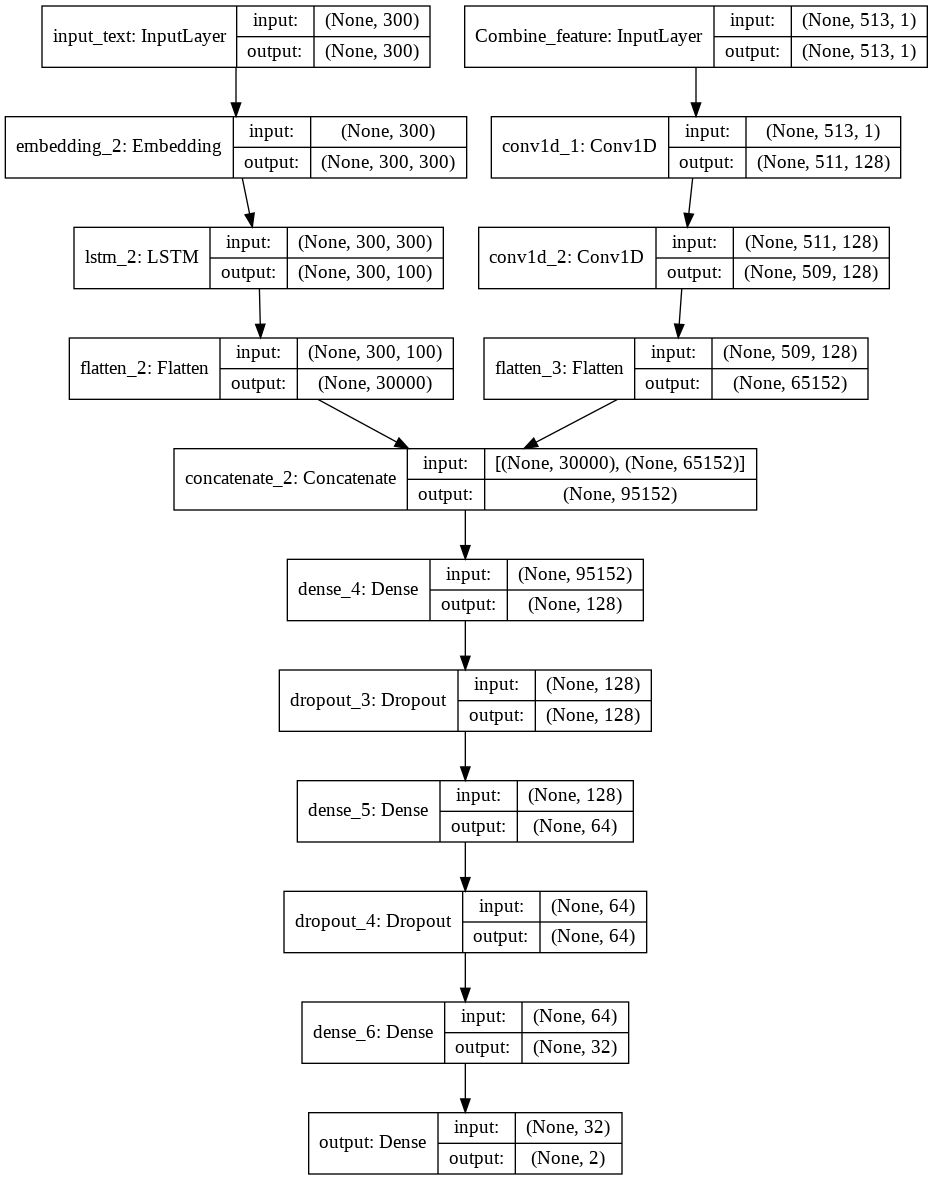

In [42]:
from keras.utils import plot_model
import pydot_ng as pydot
plot_model(model, show_shapes=True, show_layer_names=True, to_file='model3.png')
from IPython.display import Image
Image(retina=True, filename='model3.png')

**Defining train and test data for simplification**

In [0]:
train = [encoded_train,train3]
test = [encoded_test,test3]

from keras.utils import np_utils
Y_train = np_utils.to_categorical(y_train, 2) 
Y_test = np_utils.to_categorical(y_test, 2)

<h3><b>Using keras callbacks for monitoring our model performance<b></h3>
  
1. Checkpoint for saving best model
2. Earlystopping for stoping training of model if there is no change in val loss
3. ReduceROnPlateau for tracking learning rate if there is no change in val loss we reduce the learning rate 

In [0]:
from keras.callbacks import EarlyStopping

checkpoint = ModelCheckpoint("model3.h5",
                             monitor="val_loss",
                             mode="min",
                             save_best_only = True,
                             verbose=1)

earlystop = EarlyStopping(monitor = 'val_loss', 
                            mode="min",
                            min_delta = 0, 
                            patience = 5,
                            verbose = 1,
                            restore_best_weights = True)

reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.2, patience = 2, verbose = 1, min_delta = 0.0001)

#combining in single so that we will pass callbacks in model.fit
callbacks = [checkpoint,earlystop,reduce_lr]

### Defining our own roc_auc_score 

**We can define own function for auc score or else after training the model we can use sklearn auc to calculate auc but defining function is a feasible way of doing**

In [0]:
# Defining Custom ROC-AUC Metrics
from sklearn.metrics import roc_auc_score

def auc(y_true, y_pred):
    if len(np.unique(y_true[:,1])) == 1:
        return 0.5
    else:
        return roc_auc_score(y_true, y_pred)

def auroc(y_true, y_pred):
    return tf.py_func(auc, (y_true, y_pred), tf.double)

**We will be using adam optimizer for model training since it best for model**

In [0]:
adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

**Before training our model we need to compile our model why? bcoz it lets model to know what are the parameter we will be using**

In [35]:
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=[auroc])

W0905 08:05:11.168302 140092391679872 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:793: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0905 08:05:11.194102 140092391679872 deprecation.py:323] From <ipython-input-33-574376673a91>:10: py_func (from tensorflow.python.ops.script_ops) is deprecated and will be removed in a future version.
Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, there are two
    options available in V2.
    - tf.py_function takes a python function which manipulates tf eager
    tensors instead of numpy arrays. It's easy to convert a tf eager tensor to
    an ndarray (just call tensor.numpy()) but having access to eager tensors
    means `tf.py_function`s can use accelerators such as GPUs as well as
    being differentiable using a gradient tape.
    - tf.numpy_function maintains the semantics of the deprecated tf.py_func
    (it is not differentiable,

### Training our model 

In [48]:
history = model.fit(train,Y_train,batch_size=512,
                        epochs=30,validation_data=(test,Y_test),callbacks=callbacks)

W0905 06:53:48.954840 139875144828800 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 87398 samples, validate on 21850 samples
Epoch 1/30
87398/87398 [==============================] - 104s 1ms/step - loss: 0.7335 - auroc: 0.6728 - val_loss: 0.5553 - val_auroc: 0.7408

Epoch 00001: val_loss improved from inf to 0.55533, saving model to model3.h5
Epoch 2/30
87398/87398 [==============================] - 99s 1ms/step - loss: 0.4970 - auroc: 0.7390 - val_loss: 0.4866 - val_auroc: 0.7563

Epoch 00002: val_loss improved from 0.55533 to 0.48660, saving model to model3.h5
Epoch 3/30
87398/87398 [==============================] - 99s 1ms/step - loss: 0.4470 - auroc: 0.7544 - val_loss: 0.4344 - val_auroc: 0.7602

Epoch 00003: val_loss improved from 0.48660 to 0.43443, saving model to model3.h5
Epoch 4/30
87398/87398 [==============================] - 100s 1ms/step - loss: 0.4235 - auroc: 0.7606 - val_loss: 0.4297 - val_auroc: 0.7648

Epoch 00004: val_loss improved from 0.43443 to 0.42970, saving model to model3.h5
Epoch 5/30
87398/87398 [==============================] 

In [49]:
score = model.evaluate(test,Y_test,batch_size=512)
score

21850/21850 [==============================] - 9s 427us/step


[0.3717727485128617, 0.7729222032900412]

### Plot

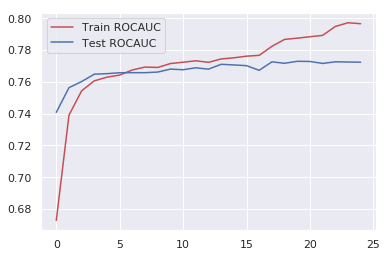

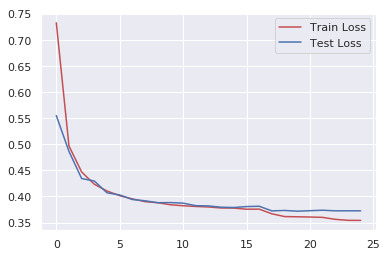

In [50]:
sns.set()
plt.plot(history.history['auroc'], 'r')
plt.plot(history.history['val_auroc'], 'b')
plt.legend({'Train ROCAUC': 'r', 'Test ROCAUC':'b'})
plt.show()


plt.plot(history.history['loss'], 'r')
plt.plot(history.history['val_loss'], 'b')
plt.legend({'Train Loss': 'r', 'Test Loss':'b'})
plt.show()

# Model with 4 layer

In [0]:
inp_conv =  Input(shape=(513, 1),name='Combine_feature')
x1 = Conv1D(filters=128, kernel_size=3, activation='relu',kernel_initializer="he_normal")(inp_conv)
x1 = Conv1D(filters=256, kernel_size=5, activation='relu',kernel_initializer="he_normal")(x1)
x1 = Conv1D(filters=128, kernel_size=5, activation='relu',kernel_initializer="he_normal")(x1)
x3 = Flatten()(x1)

x = concatenate([flatten_essay_layer,x3])
x = BatchNormalization()(x)
x = Dense(128,activation="relu",kernel_initializer="he_normal",kernel_regularizer=regularizers.l2(0.001))(x)
x = Dropout(0.5)(x)
x = Dense(64,activation="relu",kernel_initializer="he_normal",kernel_regularizer=regularizers.l2(0.001))(x)
x = Dropout(0.3)(x)
x = Dense(32,activation="relu",kernel_initializer="he_normal",kernel_regularizer=regularizers.l2(0.001))(x)
x = BatchNormalization()(x)
output = Dense(2, activation='softmax', name='output_model_4_layer')(x)
model = Model(inputs=[input_essay_text,inp_conv],outputs=[output])

In [0]:
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=[auroc])

In [42]:
history = model.fit(train,Y_train,batch_size=512,epochs=20,validation_data=(test,Y_test),callbacks=callbacks)

Train on 87398 samples, validate on 21850 samples
Epoch 1/20
87398/87398 [==============================] - 129s 1ms/step - loss: 0.8286 - auroc: 0.5767 - val_loss: 0.6382 - val_auroc: 0.6942

Epoch 00001: val_loss improved from inf to 0.63817, saving model to model3.h5
Epoch 2/20
87398/87398 [==============================] - 127s 1ms/step - loss: 0.5838 - auroc: 0.7061 - val_loss: 0.5460 - val_auroc: 0.7373

Epoch 00002: val_loss improved from 0.63817 to 0.54598, saving model to model3.h5
Epoch 3/20
87398/87398 [==============================] - 126s 1ms/step - loss: 0.5096 - auroc: 0.7372 - val_loss: 0.4860 - val_auroc: 0.7483

Epoch 00003: val_loss improved from 0.54598 to 0.48603, saving model to model3.h5
Epoch 4/20
87398/87398 [==============================] - 127s 1ms/step - loss: 0.4742 - auroc: 0.7520 - val_loss: 0.4667 - val_auroc: 0.7572

Epoch 00004: val_loss improved from 0.48603 to 0.46670, saving model to model3.h5
Epoch 5/20
87398/87398 [==============================

In [43]:
score = model.evaluate(test,Y_test,batch_size=512)
score

21850/21850 [==============================] - 11s 523us/step


[0.4032303564308437, 0.7667753614939429]

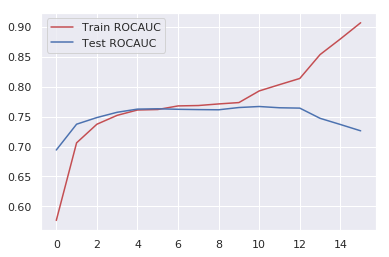

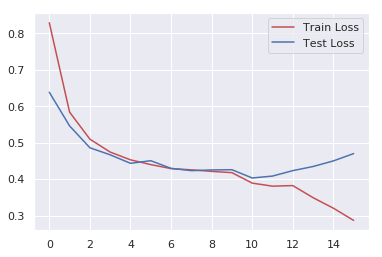

In [44]:
sns.set()
plt.plot(history.history['auroc'], 'r')
plt.plot(history.history['val_auroc'], 'b')
plt.legend({'Train ROCAUC': 'r', 'Test ROCAUC':'b'})
plt.show()


plt.plot(history.history['loss'], 'r')
plt.plot(history.history['val_loss'], 'b')
plt.legend({'Train Loss': 'r', 'Test Loss':'b'})
plt.show()

# Conclusion

1. First tried with simple model or baseline model got auc of 0.50 which is bad.
2. Tried regularizer like dropout and BatchNormalization got auc more then 0.50 i.e around 0.70.
3. Tried various featurization technique auc was approx same in every featurization.
4. Using Bi-directional and LSTM achieved more auc then 0.70 i.e around 0.76
5. Tried adding more features like time based, word count, text length, sentiment polarity but auc was aprrox same.
6. Tried different NLP technique like Topic modeling got auc of 0.7751
7. Best model was featurization and extra feature of topic modeling.

In [1]:
from prettytable import PrettyTable

x = PrettyTable()
x.field_names = ['Model with feature','AUC']
x.add_row(['Mode with countvectorizer','0.76'])
x.add_row(['Model essay feature using LSTM','0.76'])
x.add_row(['Model essay feature using Bi-directional lstm/Gru ','0.77'])
x.add_row(['Model with convolutional layer','0.77'])
x.add_row(['Model essay feature with topic modeling as essay feature ','0.7751'])

print(x)

+-----------------------------------------------------------+--------+
|                     Model with feature                    |  AUC   |
+-----------------------------------------------------------+--------+
|                 Mode with countvectorizer                 |  0.76  |
|               Model essay feature using LSTM              |  0.76  |
|     Model essay feature using Bi-directional lstm/Gru     |  0.77  |
|               Model with convolutional layer              |  0.77  |
| Model essay feature with topic modeling as essay feature  | 0.7751 |
+-----------------------------------------------------------+--------+


1. Importing package and loading the data<br>
2. Performing EDA to get insgihts of data<br>
3. Pre-processing the data and cleaning the data<br>
4. Using featurization to convert text data into numerical form<br>
5. Defining embedding matrix and input-output for all feature<br>
6. Concatinating last layer of every feature to a single layer<br>
7. Compile and training deep learning model i.e Keras<br>
8. Tried with different hyperparameter tuning like dropout,BatchNormalization<br>
9. Final step Conclusion<br>